# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
import copy

## GW150914

Download data

In [3]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [4]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+0.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
mass = qnm_filter.Filter.mass_unit(69) # IMR mass

fit = qnm_filter.Network(**input)

Load data

In [5]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [6]:
fit.detector_alignment()

Condition data 

In [7]:
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [8]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

Determine the t_init for each detector

In [9]:
fit.first_index()

## Evidence curve

Sampling remnant mass and spin

In [10]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [11]:
index_spacing = 2
num_iteration = 25
initial_offset = -20

In [12]:
fitnew=copy.deepcopy(fit)

In [13]:
# takes approximately 1min on a laptop
t_array, saved_log_evidence = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = input['model_list'])

In [14]:
t_array_no_filter, saved_log_evidence_no_filter = qnm_filter.evidence_parallel(fitnew, index_spacing, num_iteration, 
                                                                               initial_offset, massspace, chispace, 
                                                                               num_cpu = -1, verbosity=False, 
                                                                               apply_filter=False, 
                                                                               model_list = input['model_list'])

In [15]:
saved_log_evidence /= np.log(10) # ln to lg
saved_log_evidence_no_filter /= np.log(10)

Text(0.5, 0, 't (ms)')

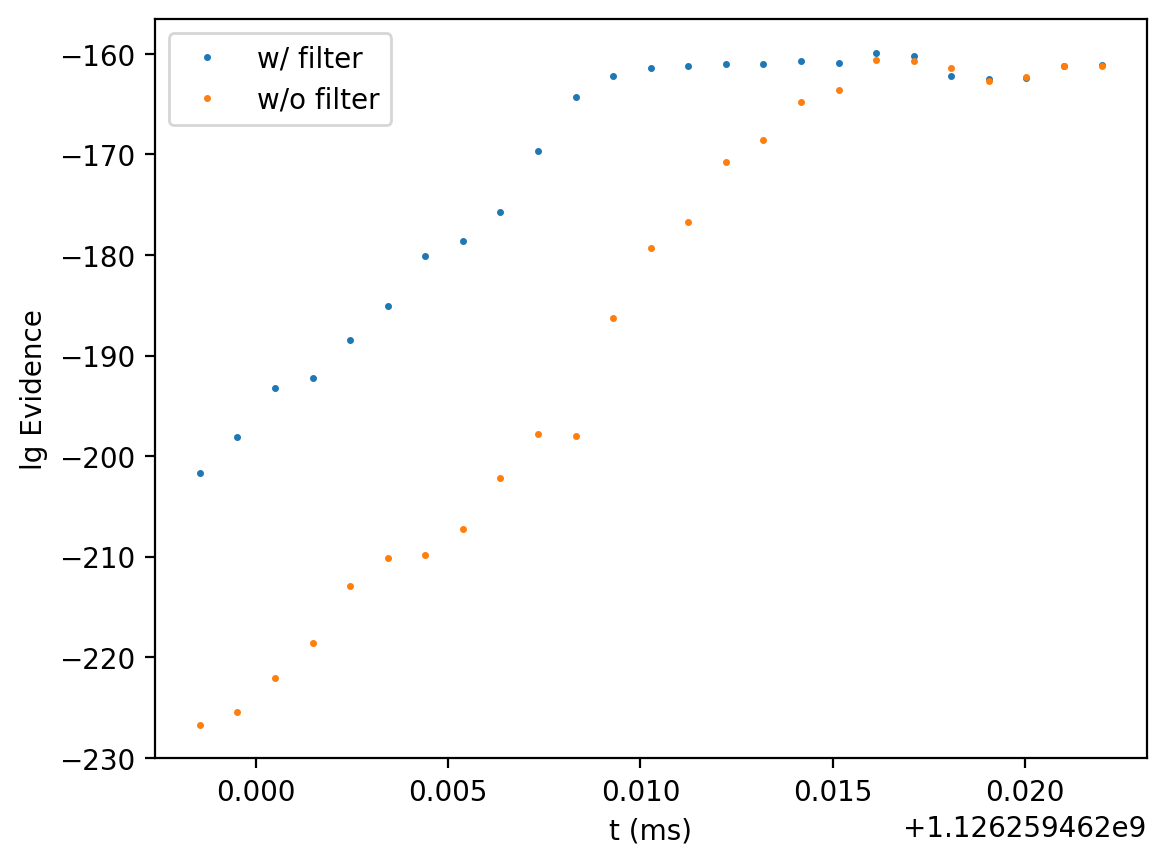

In [16]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')

In [17]:
trim_index = int(len(t_array)/2)
linear, cov = np.polyfit(t_array[trim_index:], saved_log_evidence[trim_index:], 0, cov = True)

Text(0.5, 0, 't (ms)')

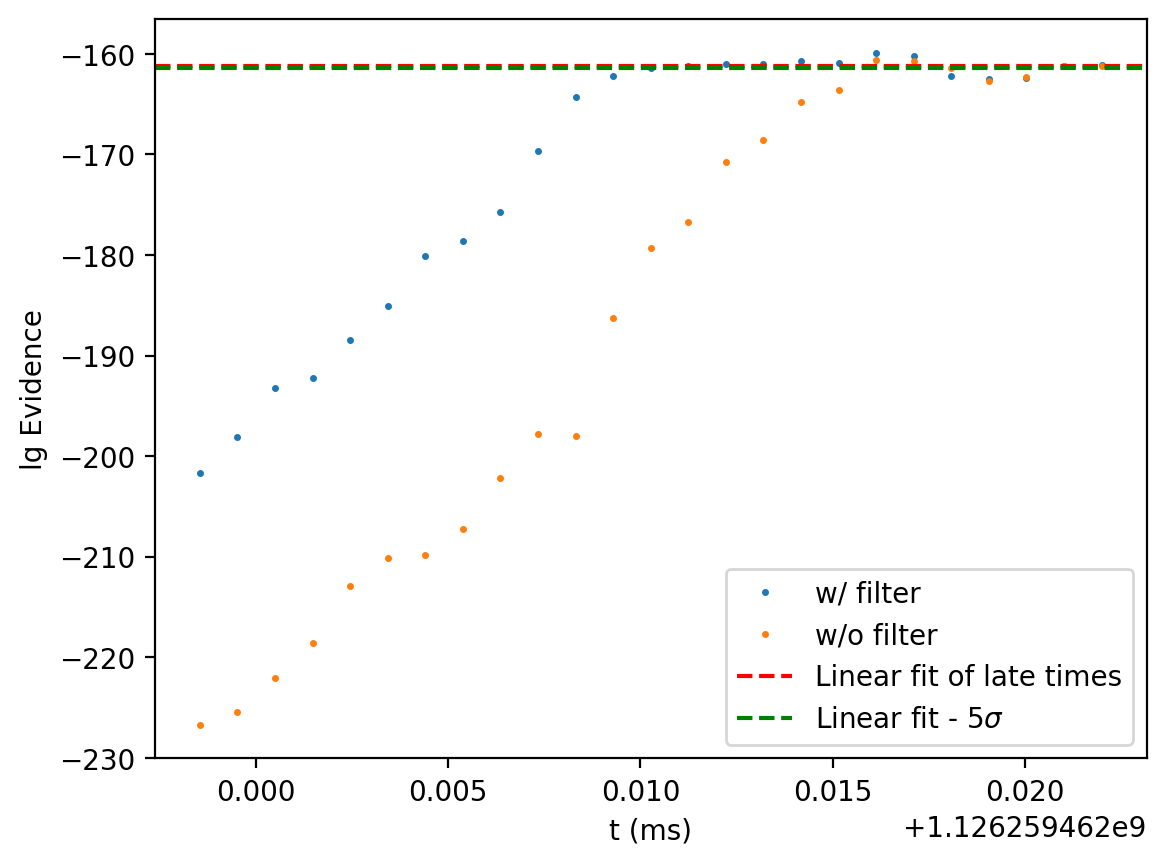

In [18]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.axhline(linear[0], c = 'r', ls = '--', label = 'Linear fit of late times')
pl.axhline(linear[0] - 5*cov[0], c = 'g', ls = '--', label = r'Linear fit - 5$\sigma$')
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')

In [19]:
index = np.argmax(saved_log_evidence > linear[0] - 5*cov[0])
time_difference = t_array[index] - input['t_init']
print("Start time determined by evidence curve: " + str(t_array[index]))
print("Difference to the IMR start time: %.1fms = %.1fM" % (1e3*time_difference, time_difference/mass))

Start time determined by evidence curve: 1126259462.4102678
Difference to the IMR start time: 2.0ms = 5.7M


In [20]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = t_array[index],
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

In [21]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.detector_alignment()
fit.condition_data('original_data', **input)
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [22]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

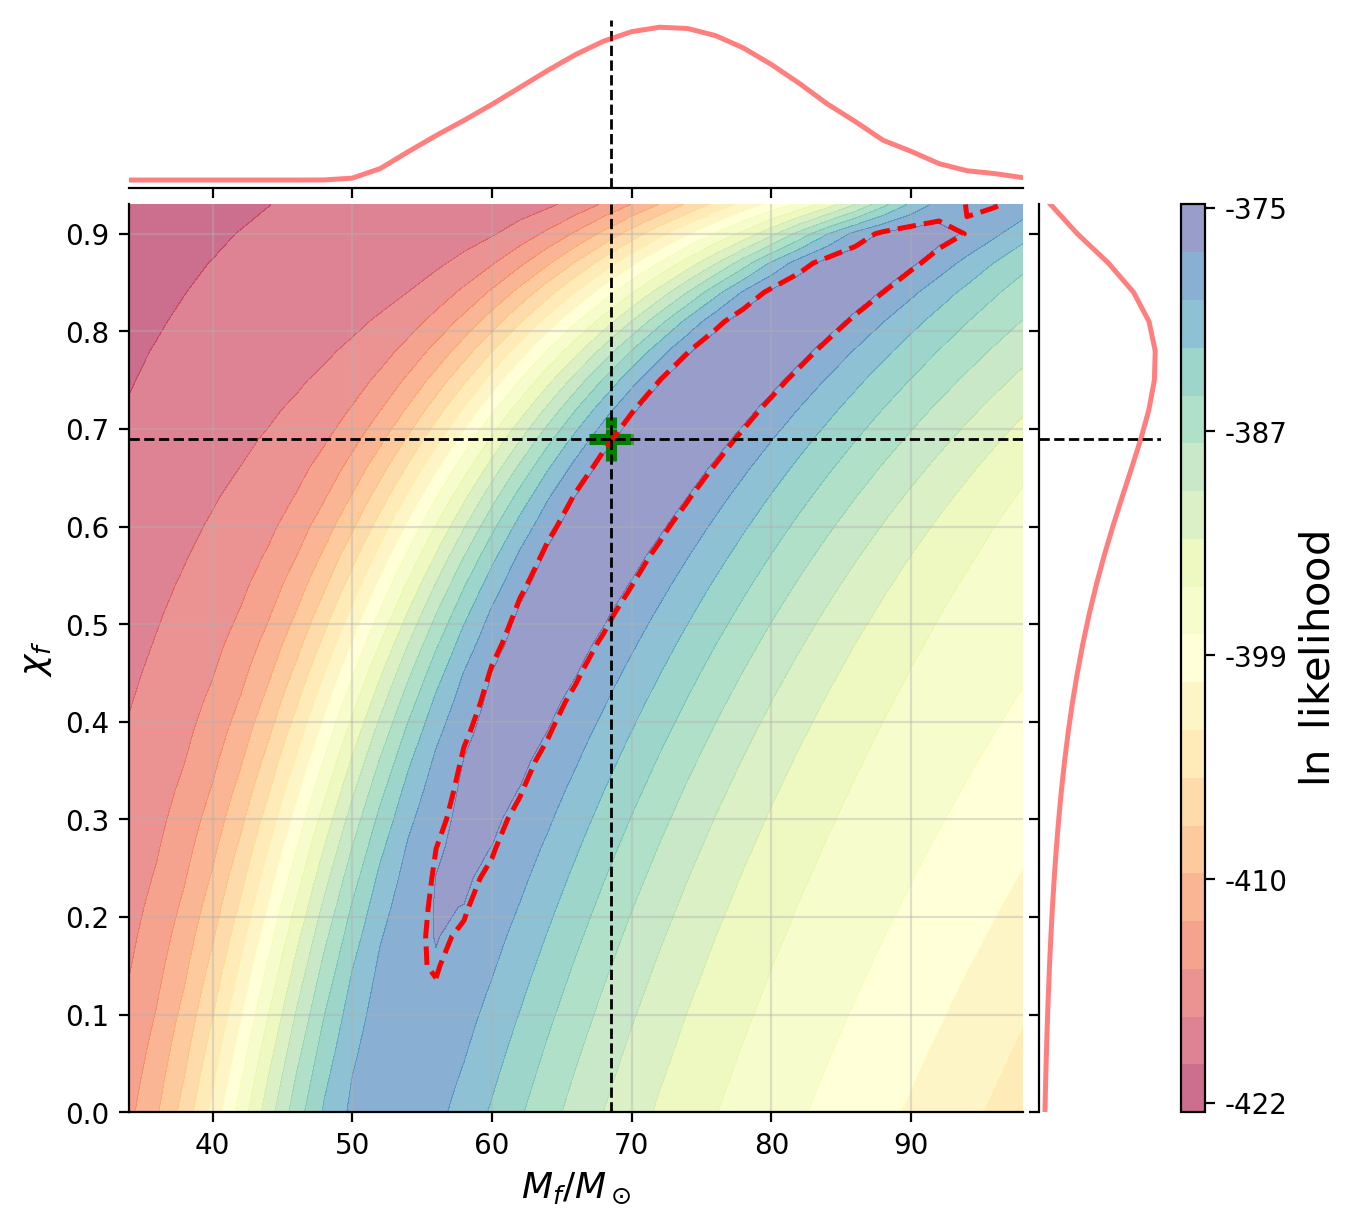

In [23]:
g = sns.JointGrid(ratio=5,space=0.1)

# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=68.5, y=0.69, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(68.5, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.69, ls='--', lw=1, c='k')
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(68.5, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.69, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))